
<font size="4"> <p style="text-align: center;">Written by Spicer Bak, July 2023  </p> </font>  

<font size="4"> **Yellowfin Autonomous surface vehicle (ASV) python post processing**  </font>  


Data are to be located in relative path as below and organized as follows

`datadir = [some]/[path]/[location]`   
this is typically `datadir = [some]/[path]/[YYYYmmdd]`  where the `YYYYmmdd` is the date of the yellowfin survey 
for this example we'll use the path `datadir = /data/yellowfin/20230327`

Note: Data in this python workflow are not placed in the `YellowFin_AcqProcessing/SampleData` archive that comes with the repository, but rather on the local machine in a location `/data/yellowfin/[YYYYmmdd]`. this is assumed to be the root directory. In the `[YYYYmmdd]` folder there are assumed to be sub-folders `nmeaData` and `s500` that have `*.dat` files in them 

<font size="5"> The workflow is as follows (details in below):</font>
1. **Download Base station data from CORS and post process**
     - RINEX data come frome the emlid post-processor in zip files.  for the purposes of this post-processing example these data are unzipped in the `datadir`
         - `/data/yellowfin/20230327/YF2Reachm2_raw_[......]_RINEX_[....]`
         - inside this folder is assumed to be `*.XXB`, `*.XXP`, `*.XXO` and most importantly the `*.pos` files which are the ppk processed output files
2. **Define data files and paths** 
    
3. **Define a python library of functions from which to call.  In my workflow i call this `yellowfinlib`. in the below the functions are simply defined and called by name.**  
4. **Load and process sonar data to *.h5 data:**
     - s500 data are assumed to be in a `s500` subfolder within the `datadir`
         - `/data/yellowfin/20230327/s500`
         - inside this folder are assumed `*.dat` files
5. **Load and process `*.pos` files, save `*.h5` file**  
6. **Merge Sonar and PPK data**  



Python3  requirements: anaconda distribution with `netCDF4` and `pygeodesy` packages added



##  1. Download Base station data from CORS and post-process Kinematic
Before processing any of the below, we're going to go through the steps to produce the Post Processing Kinematic  the PPK files, we need to make sure that we generate the proper `*.pos` file from the emlid studio. 

The emlid studo software is here: https://docs.emlid.com/emlid-studio/

To perform post-processing, you will need the following files:

   - a RINEX observation file from a base
       - These data are available here: https://geodesy.noaa.gov/UFCORS/  
       - for the rest of this we will assume use of the Duck CORS station
   - a RINEX observation file from a rover (provided in the RINEX folders)
   - a RINEX navigation file from a base or from a rover (provided in the RINEX folder) 

### 1. download CORS Data:
filled out for Duck on example data used for this effort.  Make sure to ensure the `duration in hours` encompassses the operation time of the yellowfin. I typically download the whole 24 hours on the day of operation.
![image](supportingFiles/CORS.png) 

### 2. open Emlid Studio and load files 
load rover file in top and bottom, and base `*.XXo` into the middle field

![image](supportingFiles/ppk1.png)

Data show path of rover (yellowfin ASV).  notice the colors identify type of fix.  Green is "fixed" and yellow is "float"

![image](supportingFiles/ppk2.png)


This will produce `*.pos` files for each of the Navigation (`*.XXp`) and Observation (`*.XXo`) file pairs.  The Base file will stay the same and needs to be co-timed to that of the Nav/Obs files.

**Note Antenna Height is not adjusted here it is adjusted later in the workflow**


## 2. Define data files and paths

In [46]:
## change things in this 
# establish data location paths to be used for the rest of the code base
database = r"C:\Users\RDCHLASB\Documents\repos\yellowFin_AcqProcessing-myDev\SampleData" # "/data/yellowfin/" #"../SampleData"
timeString = "20230504" # "20230327"
geoidFileLoc = r"C:\Users\RDCHLASB\Documents\repos\yellowFin_AcqProcessing-myDev\g2012bu0.bin"  # https://geodesy.noaa.gov/GEOID/  <-- acquired here, used by pygeodesy

In [63]:
import os
import yellowfinLib
import matplotlib
matplotlib.use('TkAgg')
# %matplotlib notebook / widgit
%matplotlib inline
datadir = os.path.join(database,timeString)
plotDir = os.path.join(datadir,'figures')
os.makedirs(plotDir, exist_ok=True)  # make folder structure if its not already made
# sonar data 
fpathSonar = os.path.join(datadir, 's500') # reads sonar from here
saveFnameSonar = os.path.join(datadir, f'{timeString}_sonarRaw.h5') #saves sonar file here

#NMEA data from sonar, this is not Post Processed Kinematic (PPK) data.  It is used for only cursory or 
# introductory look at the data 
fpathGNSS = os.path.join(datadir, 'nmeaData')  # load NMEA data from this location
saveFnameGNSS = os.path.join(datadir, f'{timeString}_gnssRaw.h5')  # save nmea data to this location

# RINEX data 
# look for all subfolders with RINEX in the folder name inside the "datadir" emlid ppk processor 
saveFnamePPK = os.path.join(datadir, f'{timeString}_ppkRaw.h5')


## 3. Define Yellowfinlib
The below functions were removed for clarity all detailed functions can be found in the `yellowfinlib.py` file 


# load files 
## 4. Start loading the sonar files

In [64]:
#First load Sonar Data: this loads all of the *.dat files and saves a h5 file
print(fpathSonar)
yellowfinLib.loadSonar_s500_binary(fpathSonar, outfname=saveFnameSonar, verbose=False) 

C:\Users\RDCHLASB\Documents\repos\yellowFin_AcqProcessing-myDev\SampleData\20230504\s500
found 63 sonar files for processing


100%|██████████| 63/63 [00:24<00:00,  2.57it/s]


## load NMEA files that are logged on rasberry pi

In [66]:
# then load NMEA files 
yellowfinLib.load_yellowfin_NMEA_files(fpathGNSS, saveFname=saveFnameGNSS,
                          plotfname=os.path.join(datadir, 'figures', 'GPSpath.png'))
#note these files are only used for time syncing the GNSS data

100%|██████████| 4203/4203 [00:14<00:00, 299.68it/s]


## 5. load Post processing Kinematic (PPK) files

In [67]:
# first find all the folders that have ppk data in them (*.pos files in folders that have "raw" in them) 
fldrlistPPK = [] # initalize list for appending RINEX folder in
[fldrlistPPK.append(os.path.join(datadir, fname)) for fname in os.listdir(datadir) if 'raw' in fname and '.zip' not in fname]
T_ppk = yellowfinLib.loadPPKdata(fldrlistPPK)
T_ppk.to_hdf(saveFnamePPK, 'ppk') # now save the h5 intermediate file 

loaded C:\Users\RDCHLASB\Documents\repos\yellowFin_AcqProcessing-myDev\SampleData\20230504\YF2Reachm2_raw_20230504174442_RINEX_3_03\YF2Reachm2_raw_20230504174442.pos


## 6. Now Merge the PPK and Sonar Data

 **important Note:  This script assumes the pi computer is in EST** 
 1. shift Eastern Time zone to UTC.  This this is handled with a rigid shift between da hour timeshift to UTC. This is approimated by using 2023 daylight windows where Mar 12 is the 71 day of the year and Nov 5 is the 309 day of th year. To avoid this in the future, we've shifted our vehicle's pi to UTC so as to avoid this shifting in the future.
 2. load all of the data, shift GNSS by leap second and convert ellopsiod height to NAVD88
 3. find time offset for rasberry pi timeing to GNSS time
 4. shift by this time and grab the sonar depths that you want.  We choose the smoothed algorthm created by the sonar manufacturer. 
 5. plot sonar backscatter and depth values (smoothed and instant)
 6. plot all of the data.  Make sure they overlap otherwise the time offset didn't work properly and the indices selected will be None
 7. interpolate and calculate the phase offset between the signals 
 8. show the subset signals and original input and shifted signal
 9. process the data for output by creating a common time stamp for the whole data set that matches the higher resolution data set (GNSS @10hz). then loop through that time stamp, and identify the closest sonar and gnss value.  Log the ones that meet thresholds of sonar confidence and GNSS fix quality. 
 10. output and plot final product

In [68]:
# 1. time in seconds to adjust to UTC from ET (varies depending on time of year!!!)
if int(T_ppk['datetime'].iloc[0].day_of_year) > 71 &  int(T_ppk['datetime'].iloc[0].day_of_year) < 309:
    ET2UTC = 5*60*60
else:
    ET2UTC = 4*60*60 


In [69]:
#6.2
# load all files we created in previous steps 
S1 = load_h5_to_dictionary(saveFnameSonar)
GPS = load_h5_to_dictionary(saveFnameGNSS)  # this is used for the pc time adjustement 
T_ppk = pd.read_hdf(saveFnamePPK)

# Adjust GNSS time by the Leap Seconds
T_ppk['epochTime'] = T_ppk['epochTime'] - 18 # 18 is leap second adjustment
T_ppk['datetime'] = T_ppk['datetime'] - DT.timedelta(seconds=18) # making sure both are equal

# convert raw elipsoid values from satellite measurement to that of a vertical datum.  This uses NAVD88 [m] NAD83
T_ppk['GNSS_elevation_NAVD88'] = convertEllipsoid2NAVD88(T_ppk['lat'], T_ppk['lon'], T_ppk['height'],
                                             geoidFile=geoidFileLoc)

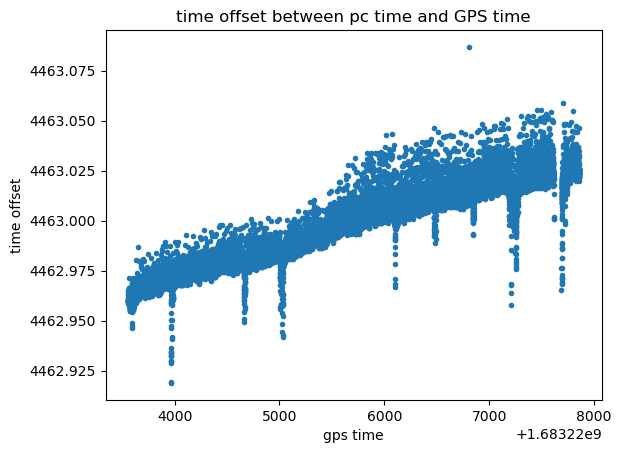

the sonar is 4463.00 seconds behind the GNSS timestamp


<Figure size 640x480 with 0 Axes>

In [71]:
#6.3
# now plot my time offset between GPS and sonar
pc_time_off = GPS['pc_time_gga'] + ET2UTC - GPS['gps_time']

# Compare GPS data to make sure timing is ok
plt.figure()
plt.plot(GPS['gps_time'], pc_time_off, '.')
plt.title('time offset between pc time and GPS time')
plt.xlabel('gps time')
plt.ylabel('time offset')
plt.show()
plt.savefig(os.path.join(plotDir, 'clockOffset.png'))
print(f'the sonar is {np.median(pc_time_off):.2f} seconds behind the GNSS timestamp')

In [70]:
# 6.4 Use the cerulean instantaneous bed detection since not sure about delay with smoothed
# adjust time of the sonar time stamp with timezone shift (ET -> UTC) and the timeshift between the computer and GPS
S1['time'] = S1['time'] + ET2UTC - np.median(pc_time_off)  # DT.timedelta(hours=5)  # convert to UTC
sonar_range = S1['smooth_depth_m'] # S1['this_ping_depth_m']
# use the above to adjust whether you want smoothed/filtered data or raw ping depth values

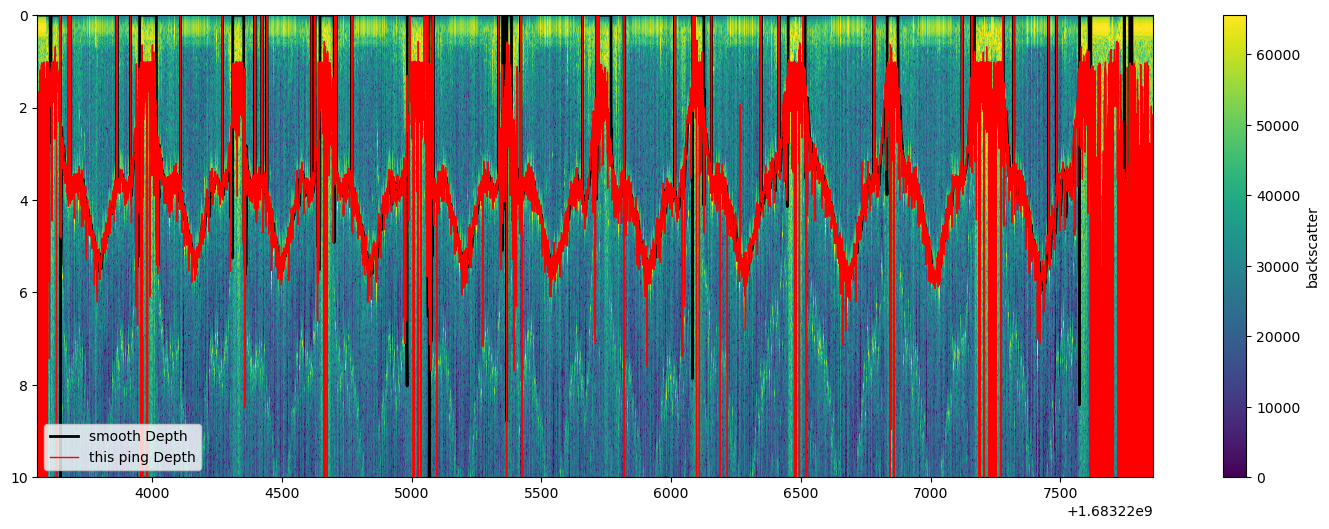

In [72]:
# 6.5 now plot sonar with time
plt.figure(figsize=(18,6))
cm = plt.pcolormesh(S1['time'], S1['range_m'], S1['profile_data'])
cbar = plt.colorbar(cm)
cbar.set_label('backscatter')
plt.plot(S1['time'], S1['smooth_depth_m'], 'k-', lw=2, label='smooth Depth')
plt.plot(S1['time'], S1['this_ping_depth_m'], 'r-', lw=1, label='this ping Depth')
plt.ylim([10, 0])
plt.legend(loc='lower left')
#plt.gca().invert_yaxis()
plt.savefig(os.path.join(plotDir, 'SonarBackScatter.png'))

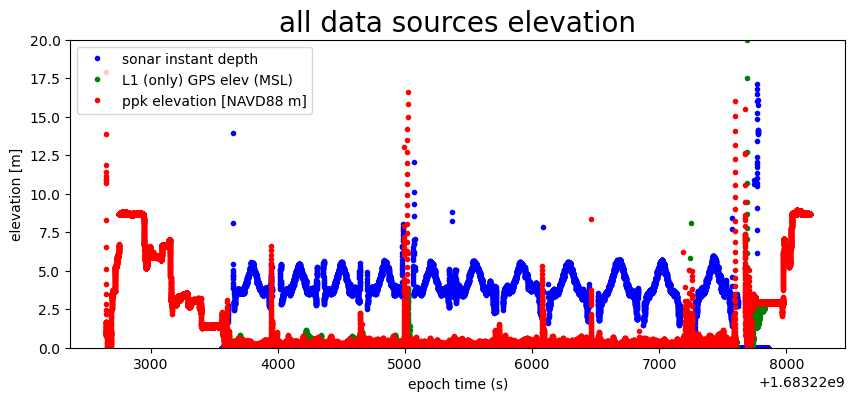

These data need to overlap!


<Figure size 640x480 with 0 Axes>

In [81]:
# 6.6 Now lets take a look at all of our data from the different sources 
plt.figure(figsize=(10, 4))
plt.title('all data sources elevation', fontsize=20)
plt.plot(S1['time'], sonar_range, 'b.', label='sonar instant depth')
plt.plot(GPS['gps_time'], GPS['altMSL'], '.g', label='L1 (only) GPS elev (MSL)')
plt.plot(T_ppk['epochTime'], T_ppk['GNSS_elevation_NAVD88'], '.r', label='ppk elevation [NAVD88 m]')
plt.ylim([0, 20])
plt.ylabel('elevation [m]')
plt.xlabel('epoch time (s)')
plt.legend()
plt.show()
plt.savefig(os.path.join(plotDir, 'AllData.png'))
print('These data need to overlap!')

In [83]:
# 6.7 # plot sonar, select indices of interest, and then second subplot is time of interest
%matplotlib tk 

plt.figure(figsize=(10,4))
plt.subplot(211)
plt.title('all data, select start/end point for measured depths\nadd extra time for PPK offset')
plt.plot(sonar_range)
# plt.ylim([0,10])
d = plt.ginput(2)

plt.subplot(212)
# Now pull corresponding indices for sonar data for same time
sonarIndicies = np.arange(np.floor(d[0][0]).astype(int), np.ceil(d[1][0]).astype(int))
plt.plot(sonar_range[sonarIndicies])
plt.title('my selected data to proceed with')
plt.tight_layout()
# plt.ylim([0,10])
plt.savefig(os.path.join(plotDir, 'subsetForCrossCorrelation.png'))


# now identify corresponding times from ppk GPS to those times of sonar that we're interested in
indsPPK = np.where((T_ppk['epochTime'] >= S1['time'][sonarIndicies[0]]) &
                   (T_ppk['epochTime'] <= S1['time'][sonarIndicies[-1]]))[0]


In [84]:
# 6.7 interpolate and calculate the phase offset between the signals
from scipy import interpolate, signal
 
## now interpolate the lower sampled (sonar 3.33 hz) to the higher sampled data (gps 10 hz)
# identify common timestamp to interpolate to at higher frequency
commonTime = np.linspace(T_ppk['epochTime'][indsPPK[0]], T_ppk['epochTime'][indsPPK[-1]],
                        int((T_ppk['epochTime'][indsPPK[-1]] - T_ppk['epochTime'][indsPPK[0]])/.1), endpoint=True)

f = interpolate.interp1d(S1['time'], sonar_range) #, fill_value='extrapolate')
sonar_range_i = f(commonTime)
f = interpolate.interp1d(T_ppk['epochTime'], T_ppk['height'])
ppkHeight_i = f(commonTime)
# now i have both signals at the same time stamps
phaseLagInSamps, phaseLaginTime = findTimeShiftCrossCorr(signal.detrend(ppkHeight_i),
                                                                      signal.detrend(sonar_range_i),
                                                                      sampleFreq=np.median(np.diff(commonTime)))



## Now identify period with waves over close to flat bottom
plot should open up, use left mouse button to chose 2 points that start/finish a mostly flat portion of sensed depth.  Code will then detrend and cross-correlate the two signals (GNSS and sonar) to find a time offset between the two to do fine tuning of time adjustments. 

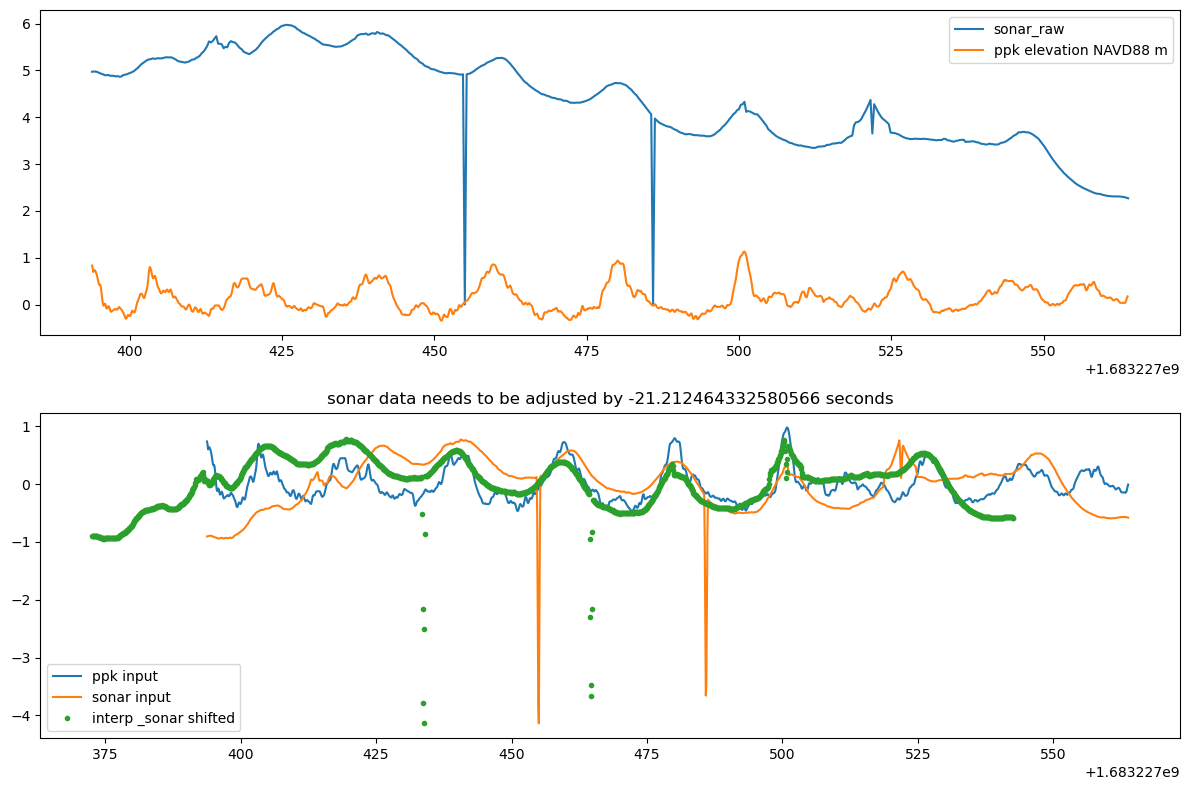

sonar data needs to be adjusted by -21.212 seconds


<Figure size 640x480 with 0 Axes>

In [85]:
# 6.8 show the subset signals and original input and shifted signal
%matplotlib inline
# now make figure where i have subset that only looks at sonar elevations and GPS elevations
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(S1['time'][sonarIndicies], sonar_range[sonarIndicies], label='sonar_raw')
plt.plot(T_ppk['epochTime'][indsPPK], T_ppk['GNSS_elevation_NAVD88'][indsPPK], label='ppk elevation NAVD88 m')
plt.legend()
plt.subplot(212)
plt.title(f"sonar data needs to be adjusted by {phaseLaginTime} seconds")
plt.plot(commonTime, signal.detrend(ppkHeight_i), label='ppk input')
plt.plot(commonTime, signal.detrend(sonar_range_i), label='sonar input')
plt.plot(commonTime+phaseLaginTime, signal.detrend(sonar_range_i), '.', label='interp _sonar shifted')
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(plotDir, 'subsetAfterCrossCorrelation.png'))

print(f"sonar data needs to be adjusted by {phaseLaginTime:.3f} seconds")

Now we have our timeshift for the sonar data and we have this properly synced up with the ppk lat/lons.  let's work on combining and exporting these data to NAVD88 elevations.  Here we create a common time stamp to the 0.1 second which is the higher resolution of the 2 data sources (GNSS is 10hz, sonar is 3 hz).  

In [77]:
## now process all data for saving to file
antenna_offset = 0.25 # meters between the antenna phase center and sounder head
PPKqualityThreshold = 1
smoothedSonarConfidence = 60
sonar_time_out = S1['time'] + phaseLaginTime

## ok now put the sonar data on the GNSS timestamps which are decimal seconds.  We can do this with sonar_time_out,
# because we just adjusted by the phase lag to make sure they are timesynced.
timeOutInterpStart =  np.ceil(sonar_time_out.min() * 10)/10 # round to nearest 0.1
timeOutInterpEnd = np.floor(sonar_time_out.max() * 10)/10   # round to nearest 0.1
# create a timestamp for data to be output and in phase with that of the ppk gps data which are on the 0.1 s
time_out = np.linspace(timeOutInterpStart, timeOutInterpEnd, int((timeOutInterpEnd - timeOutInterpStart)/0.1),
                       endpoint=True)

print("here's where some better filtering could be done, probably worth saving an intermediate product here for future "
      "revisit")
print(f"for now we're only saving/logging values that have a GNSS fix quality of {PPKqualityThreshold} and a sonar confidence > {smoothedSonarConfidence}")

# now put relevant GNSS and sonar on output timestamps
#initalize out variables
sonar_smooth_depth_out, sonar_smooth_confidence_out = np.zeros_like(time_out)*np.nan, np.zeros_like(time_out)*np.nan
sonar_instant_depth_out, sonar_instant_confidence_out  = np.zeros_like(time_out)*np.nan, np.zeros_like(time_out)*np.nan
sonar_backscatter_out = np.zeros((time_out.shape[0], S1['range_m'].shape[0]))*np.nan
lat_out, lon_out = np.zeros_like(time_out)*np.nan, np.zeros_like(time_out)*np.nan
elevation_out, fix_quality = np.zeros_like(time_out)*np.nan, np.zeros_like(time_out)*np.nan


# loop through my common time (.1 s increment) and find associated sonar and gnss values
# this might be 
for tidx, tt in tqdm.tqdm(enumerate(time_out)):
    idxTimeMatchGNSS, idxTimeMatchGNSS = None, None
    
    #first find if theres a time match for sonar
    sonarlogic = np.abs(np.ceil(tt * 10)/10 - np.ceil(sonar_time_out*10)/10)
    if sonarlogic.min() <= 0.2: # 0.2  with a sampling of <0-2, it should identify the nearest sample (at 0.3s interval)
        idxTimeMatchSonar= np.argmin(sonarlogic)
    # then find comparable time match for ppk
    ppklogic = np.abs(np.ceil(tt * 10)/10 - np.ceil(T_ppk['epochTime'].array*10)/10)
    if ppklogic.min() <= 0.101:  # .101 handles numerics
        idxTimeMatchGNSS = np.argmin(ppklogic)
    # if we have both, then we log the data
    if idxTimeMatchGNSS is not None and idxTimeMatchSonar is not None : # we have matching data
        if T_ppk['Q'][idxTimeMatchGNSS] <= PPKqualityThreshold and S1['smoothed_depth_measurement_confidence'][idxTimeMatchSonar] > smoothedSonarConfidence:
            sonar_smooth_depth_out[tidx] = S1['smooth_depth_m'][idxTimeMatchSonar]
            sonar_instant_depth_out[tidx] = S1['this_ping_depth_m'][idxTimeMatchSonar]
            sonar_smooth_confidence_out[tidx] = S1['smoothed_depth_measurement_confidence'][idxTimeMatchSonar]
            sonar_instant_confidence_out[tidx] = S1['this_ping_depth_measurement_confidence'][idxTimeMatchSonar]
            sonar_backscatter_out[tidx] = S1['profile_data'][:, idxTimeMatchSonar]
            lat_out[tidx] = T_ppk['lat'][idxTimeMatchGNSS]
            lon_out[tidx] = T_ppk['lon'][idxTimeMatchGNSS]
            elevation_out[tidx] = T_ppk['GNSS_elevation_NAVD88'][idxTimeMatchGNSS] - antenna_offset - S1['smooth_depth_m'][
                idxTimeMatchSonar]
            fix_quality[tidx] = T_ppk['Q'][idxTimeMatchGNSS]

# identify data that are not nan's to save
idxDataToSave = np.argwhere(~np.isnan(sonar_smooth_depth_out)) # identify data that are not NaNs


here's where some better filtering could be done, probably worth saving an intermediate product here for future revisit
for now we're only saving/logging values that have a GNSS fix quality of 1 and a sonar confidence > 60


43016it [00:21, 2022.45it/s]


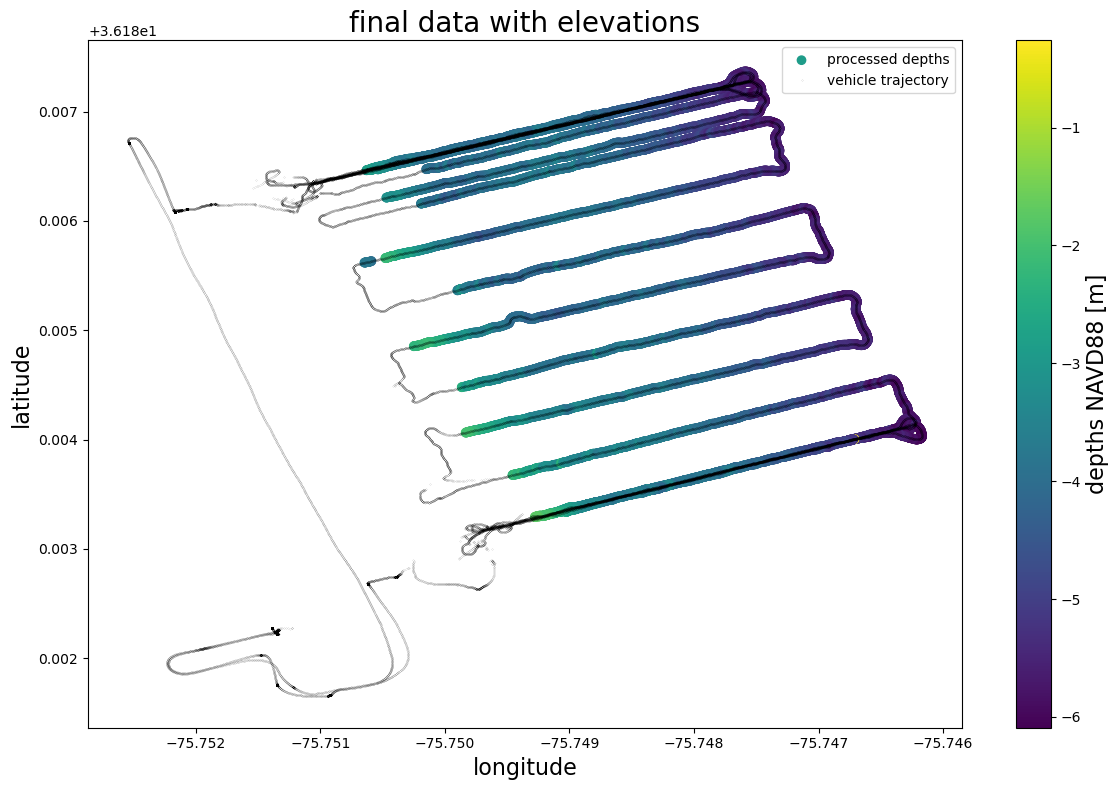

In [78]:
fs = 16
# make a final plot of all the processed data
plt.figure(figsize=(12,8))
plt.scatter(lon_out[idxDataToSave], lat_out[idxDataToSave], c=elevation_out[idxDataToSave], label='processed depths')
cbar = plt.colorbar()
cbar.set_label('depths NAVD88 [m]', fontsize=fs)
plt.plot(T_ppk['lon'], T_ppk['lat'], 'k.', ms=0.1, label='vehicle trajectory')
plt.ylabel('latitude', fontsize=fs)
plt.xlabel('longitude', fontsize=fs)
plt.title('final data with elevations', fontsize=fs+4)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(plotDir, 'FinalDataProduct.png'))


outputfile = os.path.join(datadir,f'{timeString}_finalDataProduct.h5')
with h5py.File(outputfile, 'w') as hf:
    hf.create_dataset('time', data=time_out[idxDataToSave])
    hf.create_dataset('longitude', data=lon_out[idxDataToSave])
    hf.create_dataset('latitude', data=lat_out[idxDataToSave])
    hf.create_dataset('elevation', data=elevation_out[idxDataToSave])
    hf.create_dataset('fix_quality', data=fix_quality[idxDataToSave])
    hf.create_dataset('sonar_smooth_depth', data=sonar_smooth_depth_out[idxDataToSave])
    hf.create_dataset('sonar_smooth_confidence', data=sonar_smooth_confidence_out[idxDataToSave])
    hf.create_dataset('sonar_instant_depth', data=sonar_instant_depth_out[idxDataToSave])
    hf.create_dataset('sonar_instant_confidence', data=sonar_instant_confidence_out[idxDataToSave])
    hf.create_dataset('sonar_backscatter_out', data=sonar_backscatter_out[idxDataToSave])
